In [820]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import pandas as pd
from legwork import utils, strain, psd, source
from astropy.coordinates import SkyCoord
#from CV_pop import sample_porb_from_Knigge_2011
import scipy.stats as stats
from astropy.coordinates import get_body_barycentric
from astropy.time import Time
from scipy.interpolate import griddata
import scipy.ndimage



In [821]:

max_distance = 1000 # parsecs: must be larger than 150!
#!python3 CV_pop.py --max-distance {max_distance} --mu-m1 0.7 --sigma-m1 0.001 --sigma-m2 0.001


In [822]:
filename = f"dat_maxDistance_{max_distance}.txt"
dat = pd.read_csv(filename)

In [823]:
# Read in the CDF of the orbital period distributiondistribution   

#lpdist = pd.read_csv("lpdist3.out", delim_whitespace=True, header=None, names=['logp', 'CDF'])


# Smooth the CDF with a kde to make it more continuous
#pdist['CDF'] = scipy.ndimage.gaussian_filter1d(lpdist['CDF'], 5)


#lpdist['porb'] = 10**lpdist['logp'] # convert logp to porb
#lpdist['porb'] = lpdist['porb'] / 60 # convert minutes to hours

#plt.scatter(lpdist.porb, lpdist.CDF, label='CDF')

# sample from the CDF
#nCV = 100000
#pp = np.random.uniform(0, 1, nCV)
#porb = np.interp(pp, lpdist.CDF, lpdist.porb)

#plt.hist(porb, bins=200, density=True, histtype='step')

In [824]:
dat = dat.rename(columns={'# m1[Msun]':'m1',
                          ' m2[Msun]':'m2',
                          ' inclination[rad]':'inc',
                          ' f_gw[Hz]':'f_gw',
                          ' x_gal[kpc]':'x', 
                          ' y_gal[kpc]':'y', 
                          ' z_gal[kpc]':'z',
                          ' Pala_reassigned' : 'pala'})


In [825]:
KT = pd.read_csv('kniggeTable.csv')
PT = pd.read_hdf('Pala_2020_dat_combo.h5')


[4.53711398 4.53712625 4.53713853 ... 5.04714366 5.04714746 5.04715125]


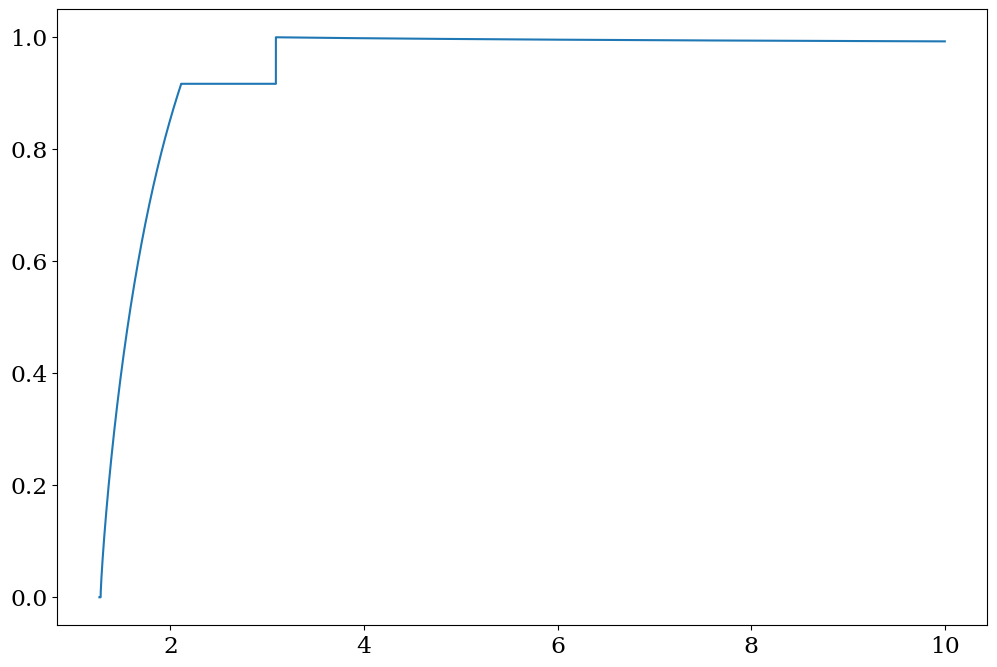

In [826]:

# Generate CDF of the orbital period distribution

porbGrid = np.linspace(76/60, 10, 100000) # hours
x = np.log10(porbGrid*60) # log10 of porb in minutes

# Generate the model CDF
modelCDF = np.zeros(len(porbGrid))
ix = porbGrid < (76.78/60)
modelCDF[ix] = 0

ix = (porbGrid >= (76.78/60)) & (porbGrid <= 2.11)
xx = x[ix] - 1.885
modelCDF[ix] = 1.98 * ( (xx + xx**(3/4)) / (1 + xx + xx**2) )

ix = (porbGrid > 2.11) & (porbGrid < 3.09)
modelCDF[ix] = 0.84

ix = porbGrid >= 3.09
xx = x[ix] + 2.269
print(xx)
modelCDF[ix] = 0.26 * ( (xx + xx**(3/4)) / (1 + xx + xx**2) ) + 0.84

#Normalize the model CDF
modelCDF = modelCDF / np.max(modelCDF)

# plot the model CDF
plt.plot(porbGrid, modelCDF, label='Model CDF')

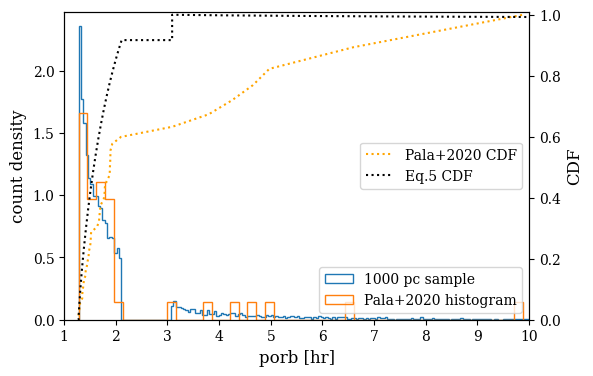

In [846]:
plt.figure(figsize=(6, 4))
plt.hist(1/(dat.f_gw/2) / 3600, bins=200, density=True, histtype='step', label=f'{max_distance} pc sample')
#plt.hist(KT.Per, density=True, bins=50, histtype='step', label='Knigge+2011 histogram')
plt.hist(PT.porb/60, density=True, histtype='step', bins=50, label='Pala+2020 histogram')
plt.xlabel('porb [hr]', size=12)
plt.ylabel('count density', size=12)
plt.legend(prop={'size':12})
plt.tick_params('both', labelsize=10)
plt.xlim(1, 10)
# move legend to bottom right
plt.legend(loc='lower right', prop={'size':10})


# Include CDF of PT.porb on right y-axis
# sort PT.porb
PT = PT.sort_values(by='porb')

# generate CDF of PT.porb
palaCDF = np.cumsum(PT.porb/60) / np.sum(PT.porb/60) 
# Normalize the CDF
palaCDF = palaCDF / np.max(palaCDF)
#plot PT.porb vs palaCDF on right y-axis using dotted line
ax2 = plt.gca().twinx()
ax2.plot(PT.porb/60, palaCDF, color='orange', linestyle='dotted', label='Pala+2020 CDF')

# plot modelCDF on right y-axis using solid line
ax2.plot(porbGrid, modelCDF, color='black', linestyle='dotted', label='Eq.5 CDF')

ax2.set_ylabel('CDF', size=12)
# set ax2 ylim between 0 and 1
ax2.set_ylim(0, 1.01)
ax2.tick_params('both', labelsize=10)
ax2.legend(loc='center right', prop={'size':10})

plt.savefig("porb.png")


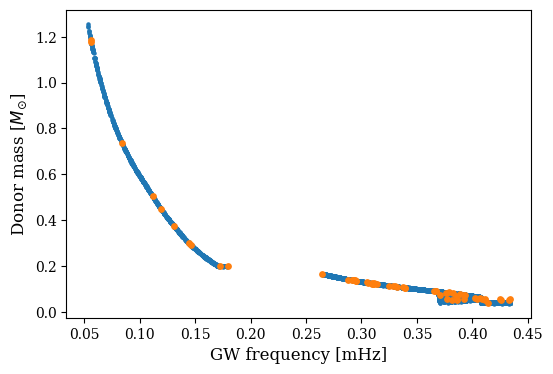

In [828]:
fig = plt.figure(figsize=(6, 4))
plt.scatter(dat['f_gw']*1000, dat['m2'], s=5)
plt.scatter(dat.loc[dat.pala > 0].f_gw*1000, dat.loc[dat.pala > 0].m2, s=15)
plt.xlabel('GW frequency [mHz]', size=12)
plt.ylabel('Donor mass [$M_{\odot}$]', size=12)
plt.tick_params('both', labelsize=10)


In [829]:
c = SkyCoord(dat.x, dat.y, dat.z, unit=u.kpc, frame='galactocentric')

dist = c.icrs.distance

mc = utils.chirp_mass(dat['m1'].values * u.Msun, dat['m2'].values * u.Msun)

In [830]:
sources = source.Source(m_1=dat['m1'].values * u.Msun, m_2=dat['m2'].values * u.Msun, 
                        ecc=np.zeros_like(dat['m1'].values), dist=dist, f_orb=dat['f_gw'].values/2 * u.Hz,
                        interpolate_g=False)

In [831]:
snr = sources.get_snr()
ASD = strain.h_0_n(m_c=mc, f_orb=dat['f_gw'].values/2 * u.Hz,  
                   ecc=np.zeros(len(mc)), dist=dist, 
                   n=2, position=None, polarisation=None, 
                   inclination=None, interpolated_g=None) * np.sqrt(4 * 3.155e7)
    

The space density within 150 pc is: 4.244131815783876e-06
Total number of sources: 7300
Total volume: 3141592653.589793
Recovered space density: 2.323662169141672e-06
0.011155781997475465 kpc
[4.14410231 4.02297153 4.51334857]
2036     98.260012
4011    106.950007
5617     81.630001
Name: f_gw, dtype: float64


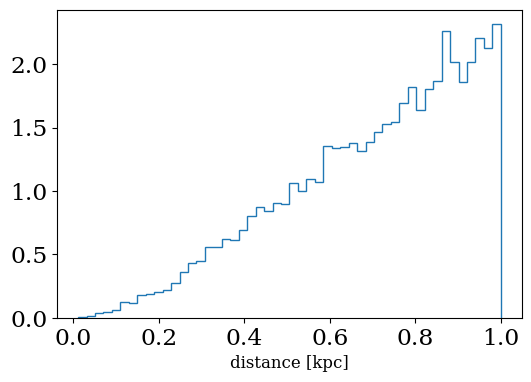

In [832]:
ind, = np.where(dat.pala == 1)
indD, = np.where(dat.pala==2)

c = SkyCoord(dat.x, dat.y, dat.z, unit=u.kpc, frame='galactocentric', representation_type='cartesian')
d = c.transform_to('barycentrictrueecliptic')
d_rounded = np.around(d.distance, decimals=5)

indCheck150, = np.where(d_rounded <= 0.15*u.kpc)

n150 = len(indCheck150)
V150 = 4/3 * np.pi * 150**3
print(f"The space density within 150 pc is: {n150/V150}")

# Sanity check: what is the space density of the sample? Should be just under 4.8e-6 N/pc^3
Nsources = d.shape[0] # total number of sources in the sample
Vol = np.pi*max_distance**3 # total volume of the sample in pc^3
print("Total number of sources:",Nsources)
print("Total volume:", Vol)
print('Recovered space density:', Nsources/Vol)

# Another check is to plot the distribution of sources in the z direction

print(d.distance.min())
plt.figure(figsize=(6, 4))
plt.hist((np.array(d.distance)), bins=50, density=True, histtype='step', label='800 pc sample')
plt.xlabel('distance [kpc]', size=12)

frequency_range = frequency_range=np.logspace(-5, 0, 1000) * u.Hz
LISA = psd.lisa_psd(frequency_range, approximate_R=False, confusion_noise='robson19')


# Print orbital periods of S/N>4 sources.
palaSNR = snr[ind]
indH = np.where(palaSNR > 4)
#print(palaSNR)
print(palaSNR[indH])    
print(1/(dat.f_gw[ind[indH]]/2) / 60)


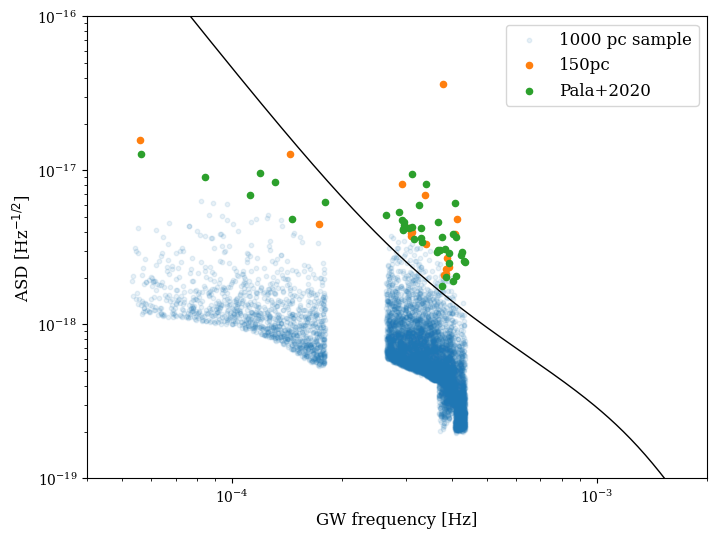

In [833]:
fig = plt.figure(figsize=(8, 6))


plt.plot(frequency_range, LISA**0.5, lw=1, c='black')   
plt.scatter(dat.f_gw, ASD, s=10, label=f'{max_distance} pc sample',alpha=1/10)
#plt.scatter(dat.f_gw[indD], ASD[indD], s=10, label='150 pc sample')
plt.scatter(dat.loc[dat.pala == 2].f_gw, ASD[indD], s=20, label='150pc')
plt.scatter(dat.loc[dat.pala == 1].f_gw, ASD[ind], s=20, label='Pala+2020')
plt.legend(prop={'size':12})
plt.yscale('log')
plt.xscale('log')
plt.xlim(4e-5, 2e-3)
plt.ylim(1e-19, 1e-16)
plt.xlabel('GW frequency [Hz]', size=12)
plt.ylabel('ASD [Hz$^{-1/2}$]', size=12)
plt.tick_params('both', labelsize=10)



In [834]:
len(dat.loc[dat.pala == 2]), len(dat.loc[dat.pala==1]), len(dat.loc[dat.pala == 2]) + len(dat.loc[dat.pala==1])

(18, 42, 60)

421.0


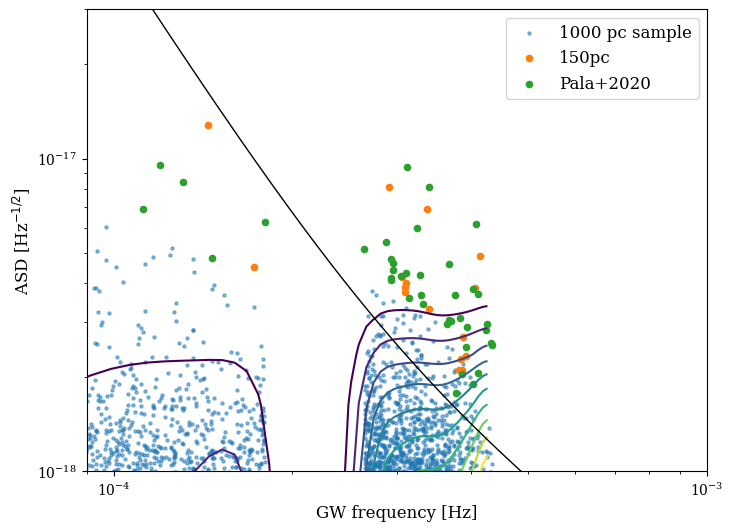

In [835]:


fig = plt.figure(figsize=(8, 6))



# Compute the 2D histogram
hist, x_edges, y_edges = np.histogram2d(np.squeeze(dat.f_gw), np.squeeze(ASD), bins=50)

print(hist.max())

# Define the contour levels
#levels = np.linspace(100, hist.max(), 10)
levels = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
          
# Smooth the data using a Gaussian filter
sigma = 2  # Adjust this parameter to control the smoothing strength
smoothed_hist = scipy.ndimage.gaussian_filter(hist, sigma)


# Plot the contour lines
plt.contour(x_edges[:-1], y_edges[:-1], smoothed_hist.T, levels=levels)


# Plot the rest
plt.plot(frequency_range, LISA**0.5, lw=1, c='black')   
plt.scatter(dat.f_gw, ASD, s=5, alpha= 0.5, label=f'{max_distance} pc sample')
#plt.scatter(dat.f_gw[indD], ASD[indD], s=10, label='150 pc sample')
plt.scatter(dat.loc[dat.pala == 2].f_gw, ASD[indD], s=20, label='150pc')
plt.scatter(dat.loc[dat.pala == 1].f_gw, ASD[ind], s=20, label='Pala+2020')
plt.legend(prop={'size':12})
plt.yscale('log')
plt.xscale('log')
plt.xlim(9e-5, 1e-3)
plt.ylim(1e-18, 3e-17)
plt.xlabel('GW frequency [Hz]', size=12)
plt.ylabel('ASD [Hz$^{-1/2}$]', size=12)
plt.tick_params('both', labelsize=10)


plt.savefig("asd.png")

# LISA Processing

The LISA processing steps require two different installations of the `ldasoft` repository. 
The current release has the spectral modeling algorithm `noise_mcmc` used for fitting the confusion noise level of the simulated data. To produce the simulated data you must roll back to `ldasoft` git commit `5e80706a7` for the `FisherGalaxy` install. For the user man

The input WDWD population used here comes from the LISA Data Challenge (LDC) _Sangria_ training data set [LDC2a-v1](https://lisa-ldc.lal.in2p3.fr/challenge2a)

Generating the simulated LISA data and fitting for the resultant noise spectra takes O(hours). For convenience we include the output data files to produce the confusion noise spectrum plots.

In [836]:
# Create input LDC galaxy containing the CV population

#!cat full_galaxy.dat "dat_maxDistance_{max_distance}_GW.txt" > full_galaxy_plus_CVs.dat

In [837]:
# Simulate LISA data using LDC-only galaxy, estimate which sources are resolvable, 
# create the residual galaxy after removal of resolvable sources, and reformat output 
# for the confusion noise plot

#!bash run.sh
#!awk '{print $1,$4,$5,$6,$7}' Galaxy_XAE.dat > lisa_data_no_cvs.dat
#!awk '{print $1,$4,$5,$6,$7}' Galaxy_XAE_R1.dat > lisa_residual_no_cvs.dat
#!cp Confusion_XAE_1.dat noise.dat

In [838]:
# Run Bayesian spectral fittingn code on residual to get noise level, and reformat output for plot

#!noise_mcmc --data lisa_residual_no_cvs.dat --duration 125829120 --fmin 0.0001 --samples 524288 --sangria --steps 1000 
#!mv data/current_interpolated_spline_points.dat psd_no_cvs.dat

In [839]:
# Simulate LISA data using LDC-only galaxy with CVs include, estimate which sources are resolvable, 
# create the residual galaxy after removal of resolvable sources, and reformat output 
# for the confusion noise plot

#!bash run_cvs.sh
#!awk '{print $1,$4,$5,$6,$7}' Galaxy_XAE_R1.dat > lisa_residual_w_cvs.dat
#!awk '{print $1,$4,$5,$6,$7}' Galaxy_XAE.dat > lisa_data_w_cvs.dat

In [840]:
# Run Bayesian spectral fittingn code on residual to get noise level, and reformat output for plot

#!noise_mcmc --data lisa_residual_w_cvs.dat --duration 125829120 --fmin 0.0001 --samples 524288 --sangria --steps 1000 
#!mv data/current_interpolated_spline_points.dat psd_w_cvs.dat

In [841]:
# The money plot

fig = plt.figure(figsize=(8, 6))
                   
data=np.loadtxt('lisa_data_w_cvs.dat')
residual=np.loadtxt('lisa_residual_w_cvs.dat')
cv_confusion=np.loadtxt('psd_w_cvs.dat')
wdwd_confusion=np.loadtxt('psd_no_cvs.dat')
noise=np.loadtxt('noise.dat')

plt.plot(data[:,0],np.sqrt(data[:,1]*data[:,1]+data[:,2]*data[:,2]),label='data',color="gray")   
plt.plot(residual[:,0],np.sqrt(residual[:,1]*residual[:,1]+residual[:,2]*residual[:,2]),label='residual',color="lightgray")   
plt.plot(cv_confusion[:,0],np.sqrt(cv_confusion[:,1]),label='cv confusion',color="tab:blue", linewidth=3)   
plt.plot(wdwd_confusion[:,0],np.sqrt(wdwd_confusion[:,1]),label='wdwd confusion',color="tab:orange", linewidth=3)   
plt.plot(noise[:,0],np.sqrt((noise[:,3]-noise[:,4])/2),label='instrument noise',color="black", linestyle='dashed')   

plt.legend(prop={'size':12})
plt.yscale('log')
plt.xscale('log')
plt.xlim(1e-4, 4e-3)
plt.ylim(1e-24, 1e-18)

plt.xlabel('GW frequency [Hz]', size=12)
plt.ylabel('ASD [Hz$^{-1/2}$]', size=12)
plt.tick_params('both', labelsize=10)


plt.savefig("spectra.png")

FileNotFoundError: lisa_data_w_cvs.dat not found.

<Figure size 800x600 with 0 Axes>